#  Entraînement Naive Bayes - Détection de Défauts de Crédit

## Contexte
- **Problème**: Déséquilibre 80-20 (pas de défaut vs défaut)
- **Solution**: Tester 4 stratégies de rééquilibrage
- **Modèle**: GaussianNB (Naive Bayes Gaussien)

## Variables
- **Features (X)**: Age, Income, LoanAmount, MonthsEmployed, InterestRate
- **Target (y)**: Default (0 = pas de défaut, 1 = défaut)

In [11]:
import sys
print(sys.executable)


c:\Users\HP\AppData\Local\Programs\Python\Python312\python.exe


In [12]:
!{sys.executable} -m pip install imbalanced-learn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Charger data_standardized.csv
df = pd.read_csv('../Data/data_standardized.csv')




In [15]:
print(f"Shape: {df.shape}")
print("\nPremières lignes:")
print(df.head())



Shape: (255347, 7)

Premières lignes:
   Unnamed: 0       Age    Income  LoanAmount  MonthsEmployed  InterestRate  \
0           0  0.833990  0.089693   -1.086833        0.590533      0.261771   
1           1  1.701221 -0.823021   -0.044309       -1.285731     -1.308350   
2           2  0.166888  0.043854    0.022715       -0.968209      1.156831   
3           3 -0.767053 -1.303452   -1.168538       -1.718715     -0.967805   
4           4  1.100830 -1.592855   -1.671921       -1.487790     -1.052188   

   Default  
0        0  
1        0  
2        1  
3        0  
4        0  


In [16]:
print("\nInfo sur les colonnes:")
print(df.info())


Info sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      255347 non-null  int64  
 1   Age             255347 non-null  float64
 2   Income          255347 non-null  float64
 3   LoanAmount      255347 non-null  float64
 4   MonthsEmployed  255347 non-null  float64
 5   InterestRate    255347 non-null  float64
 6   Default         255347 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 13.6 MB
None


In [17]:
# Analyser la distribution de Default
print("Distribution de Default:")
print(df['Default'].value_counts())
print("\nPourcentages:")
print(df['Default'].value_counts(normalize=True) * 100)

Distribution de Default:
Default
0    225694
1     29653
Name: count, dtype: int64

Pourcentages:
Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64


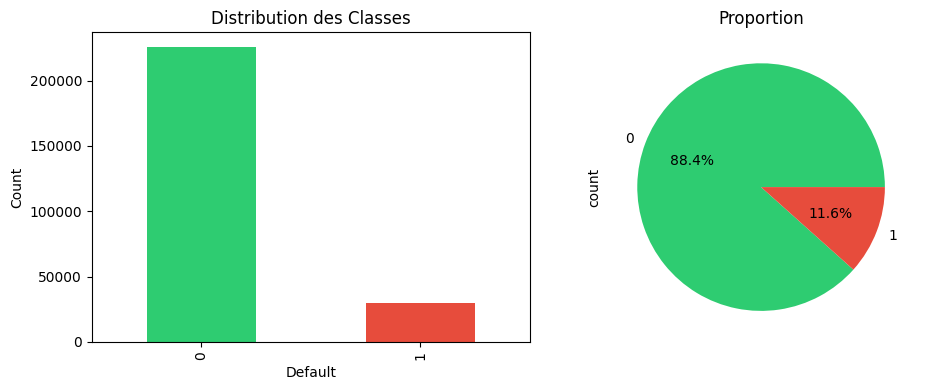

In [18]:
# Visualisation
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['Default'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Distribution des Classes')
plt.xlabel('Default')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
df['Default'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                    colors=['#2ecc71', '#e74c3c'])
plt.title('Proportion')
plt.tight_layout()
plt.show()

In [19]:
# Séparer features et target
X = df.drop('Default', axis=1)
y = df['Default']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")



X shape: (255347, 6)
y shape: (255347,)

Features: ['Unnamed: 0', 'Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'InterestRate']


In [20]:
# Split train/test (stratifié pour garder le ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#random_state=42 (ou n'importe quel nombre), je garantis que le split training/test reste toujours identique à chaque fois que je relances le code.
#stratify=y → on garde la même proportion de classes dans train et test pour ne pas biaiser la validation.
print(f"\nTrain: {X_train.shape[0]} exemples")
print(f"Test: {X_test.shape[0]} exemples")


Train: 204277 exemples
Test: 51070 exemples


##  Stratégies de Rééquilibrage

### 1. Sans rééquilibrage (Baseline)
Entraîner directement sur les données déséquilibrées (80-20)

### 2. SMOTE (Synthetic Minority Over-sampling)
Créer des exemples synthétiques de la classe minoritaire

### 3. Sous-échantillonnage (Random Under Sampling)
Réduire la classe majoritaire pour équilibrer

### 4. SMOTETomek (Hybride)
SMOTE + nettoyage des exemples ambigus (La méthode Tomek Links sert à nettoyer les points de la classe majoritaire qui sont trop proches de la classe minoritaire pour  distinguer les défauts des non-défauts.)

##info: 

Recall (Défaut) : capacité à retrouver les vrais défauts (classe 1). Plus c’est haut, mieux le modèle détecte les défauts.

F1-Score (Défaut) : équilibre entre recall et précision sur la classe défaut. Score moyen si beaucoup de faux positifs, score haut si très peu d’erreurs.

AUC-ROC : performance globale de discrimination entre défaut et non-défaut sur l’ensemble du test.

1- ##  Stratégies de Rééquilibrage

In [21]:
# STRATÉGIE 1: Sans rééquilibrage
print("="*50)
print("STRATÉGIE 1: SANS RÉÉQUILIBRAGE")
print("="*50)

nb_baseline = GaussianNB()
nb_baseline.fit(X_train, y_train)
y_pred_baseline = nb_baseline.predict(X_test)
y_proba_baseline = nb_baseline.predict_proba(X_test)[:, 1]

print("\n", classification_report(y_test, y_pred_baseline))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_baseline):.4f}")

STRATÉGIE 1: SANS RÉÉQUILIBRAGE

               precision    recall  f1-score   support

           0       0.88      1.00      0.94     45139
           1       0.00      0.00      0.00      5931

    accuracy                           0.88     51070
   macro avg       0.44      0.50      0.47     51070
weighted avg       0.78      0.88      0.83     51070

AUC-ROC: 0.7394


In [22]:
# STRATÉGIE 2: SMOTE
print("="*50)
print("STRATÉGIE 2: SMOTE")
print("="*50)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Avant SMOTE: {len(y_train)} exemples")
print(f"Après SMOTE: {len(y_train_smote)} exemples")
print(f"Classe 0: {sum(y_train_smote==0)}, Classe 1: {sum(y_train_smote==1)}")

nb_smote = GaussianNB()
nb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = nb_smote.predict(X_test)
y_proba_smote = nb_smote.predict_proba(X_test)[:, 1]

print("\n", classification_report(y_test, y_pred_smote))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_smote):.4f}")

STRATÉGIE 2: SMOTE
Avant SMOTE: 204277 exemples
Après SMOTE: 361110 exemples
Classe 0: 180555, Classe 1: 180555

               precision    recall  f1-score   support

           0       0.96      0.36      0.52     45139
           1       0.15      0.89      0.26      5931

    accuracy                           0.42     51070
   macro avg       0.56      0.63      0.39     51070
weighted avg       0.87      0.42      0.49     51070

AUC-ROC: 0.7380


In [23]:
# STRATÉGIE 3: Sous-échantillonnage
print("="*50)
print("STRATÉGIE 3: SOUS-ÉCHANTILLONNAGE")
print("="*50)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"Avant: {len(y_train)} exemples")
print(f"Après: {len(y_train_rus)} exemples")
print(f"Classe 0: {sum(y_train_rus==0)}, Classe 1: {sum(y_train_rus==1)}")

nb_rus = GaussianNB()
nb_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = nb_rus.predict(X_test)
y_proba_rus = nb_rus.predict_proba(X_test)[:, 1]

print("\n", classification_report(y_test, y_pred_rus))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rus):.4f}")

STRATÉGIE 3: SOUS-ÉCHANTILLONNAGE
Avant: 204277 exemples
Après: 47444 exemples
Classe 0: 23722, Classe 1: 23722

               precision    recall  f1-score   support

           0       0.94      0.63      0.75     45139
           1       0.20      0.72      0.32      5931

    accuracy                           0.64     51070
   macro avg       0.57      0.67      0.53     51070
weighted avg       0.86      0.64      0.70     51070

AUC-ROC: 0.7392


In [24]:
# STRATÉGIE 4: SMOTETomek
print("="*50)
print("STRATÉGIE 4: SMOTETOMEK")
print("="*50)

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print(f"Avant: {len(y_train)} exemples")
print(f"Après: {len(y_train_smt)} exemples")
print(f"Classe 0: {sum(y_train_smt==0)}, Classe 1: {sum(y_train_smt==1)}")

nb_smt = GaussianNB()
nb_smt.fit(X_train_smt, y_train_smt)
y_pred_smt = nb_smt.predict(X_test)
y_proba_smt = nb_smt.predict_proba(X_test)[:, 1]

print("\n", classification_report(y_test, y_pred_smt))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_smt):.4f}")

STRATÉGIE 4: SMOTETOMEK
Avant: 204277 exemples
Après: 332574 exemples
Classe 0: 166287, Classe 1: 166287

               precision    recall  f1-score   support

           0       0.96      0.37      0.53     45139
           1       0.16      0.89      0.27      5931

    accuracy                           0.43     51070
   macro avg       0.56      0.63      0.40     51070
weighted avg       0.87      0.43      0.50     51070

AUC-ROC: 0.7381


In [25]:
# Créer un tableau comparatif
results_comparison = {
    'Stratégie': ['Baseline', 'SMOTE', 'Sous-échant.', 'SMOTETomek'],
    'Recall (Défaut)': [
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rus, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_smt, output_dict=True)['1']['recall']
    ],
    'F1-Score (Défaut)': [
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_rus, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_smt, output_dict=True)['1']['f1-score']
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_proba_baseline),
        roc_auc_score(y_test, y_proba_smote),
        roc_auc_score(y_test, y_proba_rus),
        roc_auc_score(y_test, y_proba_smt)
    ]
}

comparison_df = pd.DataFrame(results_comparison)
print(comparison_df.round(4))

      Stratégie  Recall (Défaut)  F1-Score (Défaut)  AUC-ROC
0      Baseline           0.0000             0.0000   0.7394
1         SMOTE           0.8926             0.2640   0.7380
2  Sous-échant.           0.7208             0.3161   0.7392
3    SMOTETomek           0.8877             0.2650   0.7381


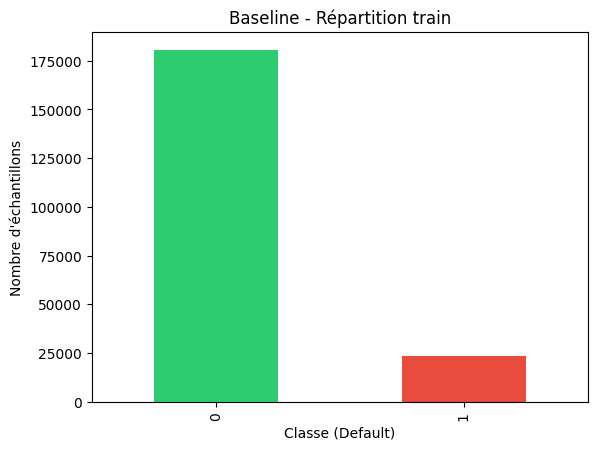

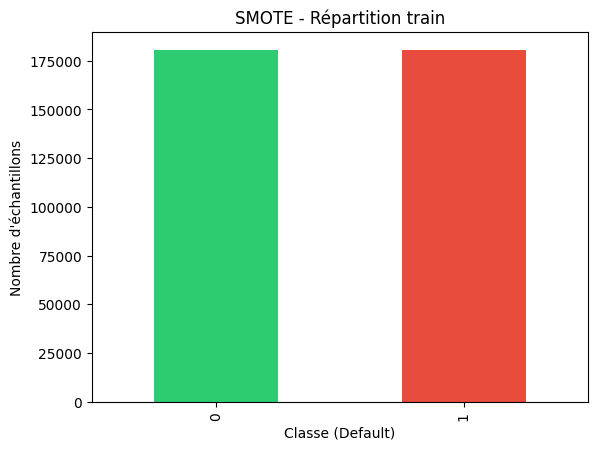

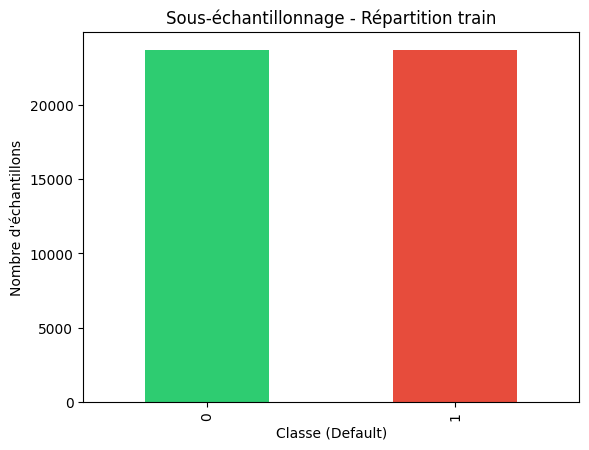

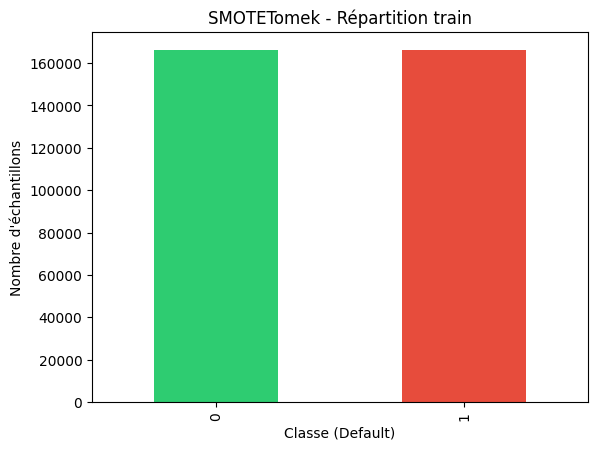

In [26]:
import matplotlib.pyplot as plt

def plot_dist(y, title):
    ax = y.value_counts().sort_index().plot(kind='bar', color=['#2ecc71','#e74c3c'])
    plt.title(title)
    plt.xlabel('Classe (Default)')
    plt.ylabel('Nombre d\'échantillons')
    plt.show()

plot_dist(y_train, "Baseline - Répartition train")
plot_dist(y_train_smote, "SMOTE - Répartition train")
plot_dist(y_train_rus, "Sous-échantillonnage - Répartition train")
plot_dist(y_train_smt, "SMOTETomek - Répartition train")


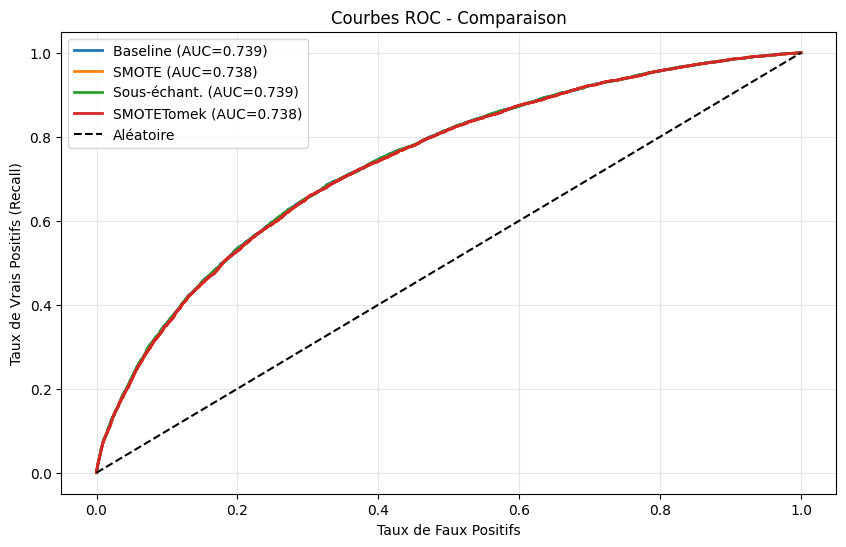

In [27]:
# Courbes ROC comparatives
plt.figure(figsize=(10, 6))

for name, y_proba in [('Baseline', y_proba_baseline), 
                       ('SMOTE', y_proba_smote),
                       ('Sous-échant.', y_proba_rus), 
                       ('SMOTETomek', y_proba_smt)]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0,1], [0,1], 'k--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs (Recall)')
plt.title('Courbes ROC - Comparaison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [28]:
import joblib

# Identifier le meilleur (basé sur F1-Score)
best_idx = comparison_df['F1-Score (Défaut)'].idxmax()
best_strategy = comparison_df.loc[best_idx, 'Stratégie']

print(f"🏆 Meilleure stratégie: {best_strategy}")



🏆 Meilleure stratégie: Sous-échant.


On choisit la stratégie de sous-échantillonnage, car elle présente le meilleur F1-score pour la détection des défauts : c'est le compromis optimal entre taux de détection (rappel) et taux d'erreur (précision) dans notre évaluation

In [29]:
# Sauvegarder le bon modèle
models = {
    'Baseline': nb_baseline,
    'SMOTE': nb_smote,
    'Sous-échant.': nb_rus,
    'SMOTETomek': nb_smt
}

best_model = models[best_strategy]
joblib.dump(best_model, '../Models/naive_bayes_best_model.pkl')
comparison_df.to_csv('../Models/naive_bayes_comparison.csv', index=False)

print("✓ Modèle sauvegardé: naive_bayes_best_model.pkl")
print("✓ Comparaison sauvegardée: naive_bayes_comparison.csv")

✓ Modèle sauvegardé: naive_bayes_best_model.pkl
✓ Comparaison sauvegardée: naive_bayes_comparison.csv
